In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_with_mpc.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_with_mpc.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [6]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_rc.shape

(100800, 46)

Apply filters:

In [12]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-10).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=0).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<0.5).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4&~f_5
    return f

In [13]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

(4761, 46)

## without random control input:

In [8]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_nc.shape

(100800, 46)

In [18]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [23]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(11151, 46)

In [24]:
n_data_nc = nn_input_nc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(5575, 46)

## From previous MPC solutions

In [29]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_mpc.shape

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



(3595, 46)

In [30]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning:

indexing past lexsort depth may impact performance.



(646, 46)

In [31]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(6460, 46)

## Concatenate everything:

In [32]:
nn_input =  pd.concat((nn_input_rc_filtered,  nn_input_nc_sampled,  nn_input_mpc_augmented), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc_sampled, nn_output_mpc_augmented), axis=0)

## Manually extend data to balance histogramms on input space

In [39]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [40]:
nn_input.shape

(41324, 46)

<IPython.core.display.Javascript object>


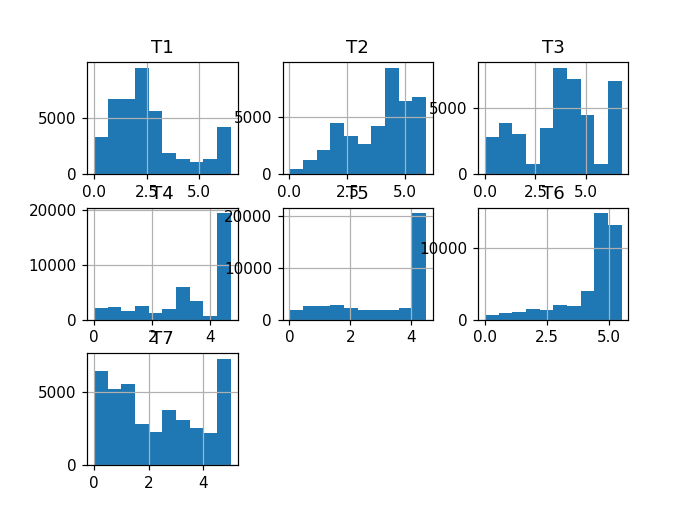

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb948051690>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb949ea2c90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb94806bf50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fb949f26c10>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb9481a1f90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb948167c50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fb94a84d490>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb94a84ec90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fb949fe2810>]], dtype=object)

In [41]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [42]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [44]:
X_train.shape

(33059, 46)

# Neural Network

## Create Model

In [94]:
n_layer = 2
n_units = 200
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               9400      
_________________________________________________________________
dense_14 (Dense)             (None, 42)                8442      
Total params: 17,842
Trainable params: 17,842
Non-trainable params: 0
_________________________________________________________________


## Train model

In [95]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [ ]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=5000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 33059 samples, validate on 8265 samples
Epoch 1/3000
33059/33059 [==============================] - 1s 21us/sample - loss: 0.1172 - val_loss: 0.0428
Epoch 2/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0488 - val_loss: 0.0496
Epoch 3/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0419 - val_loss: 0.0307
Epoch 4/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0300 - val_loss: 0.0287
Epoch 5/3000
33059/33059 [==============================] - 0s 9us/sample - loss: 0.0276 - val_loss: 0.0239
Epoch 6/3000
33059/33059 [==============================] - 0s 10us/sample - loss: 0.0230 - val_loss: 0.0211
Epoch 7/3000
33059/33059 [==============================] - 0s 15us/sample - loss: 0.0211 - val_loss: 0.0194
Epoch 8/3000
33059/33059 [==============================] - 0s 15us/sample - loss: 0.0191 - val_loss: 0.0177
Epoch 9/3000
33059/33059 [==============================] - 1s 15us/sample - loss: 

33059/33059 [==============================] - 0s 6us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 76/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 77/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 78/3000
33059/33059 [==============================] - 0s 11us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 79/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 80/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 81/3000
33059/33059 [==============================] - 0s 10us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 82/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 83/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 84/3000
33059/33059 [====

33059/33059 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 150/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 151/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 152/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 153/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 154/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 155/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 156/3000
33059/33059 [==============================] - 0s 9us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 157/3000
33059/33059 [==============================] - 0s 9us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 158/3000
33059/3305

33059/33059 [==============================] - 0s 8us/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 224/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 225/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 226/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 227/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 228/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 229/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0062 - val_loss: 0.0060
Epoch 230/3000
33059/33059 [==============================] - 0s 5us/sample - loss: 0.0062 - val_loss: 0.0060
Epoch 231/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0062 - val_loss: 0.0060
Epoch 232/3000
33059/3305

33059/33059 [==============================] - 0s 6us/sample - loss: 0.0058 - val_loss: 0.0056
Epoch 298/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0057 - val_loss: 0.0056
Epoch 299/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0057 - val_loss: 0.0056
Epoch 300/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0058 - val_loss: 0.0055
Epoch 301/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0057 - val_loss: 0.0055
Epoch 302/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0057 - val_loss: 0.0056
Epoch 303/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0057 - val_loss: 0.0055
Epoch 304/3000
33059/33059 [==============================] - 0s 9us/sample - loss: 0.0057 - val_loss: 0.0055
Epoch 305/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0057 - val_loss: 0.0055
Epoch 306/3000
33059/3305

33059/33059 [==============================] - 0s 8us/sample - loss: 0.0052 - val_loss: 0.0050
Epoch 372/3000
33059/33059 [==============================] - 0s 6us/sample - loss: 0.0052 - val_loss: 0.0050
Epoch 373/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0052 - val_loss: 0.0050
Epoch 374/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 375/3000
33059/33059 [==============================] - 0s 8us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 376/3000
33059/33059 [==============================] - 0s 7us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 377/3000
33059/33059 [==============================] - 0s 13us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 378/3000
33059/33059 [==============================] - 0s 13us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 379/3000
33059/33059 [==============================] - 0s 14us/sample - loss: 0.0051 - val_loss: 0.0050
Epoch 380/3000
33059/3

Save model:

In [93]:
model_path = './models/'
model_name = '009_man_1x200_both_datasets_filtered_mpc02'
model.save(model_path+model_name+'.h5')

# train_data_param={
#     'input_offset': input_offset,
#     'input_scaling': input_scaling,
#     'output_offset': output_offset,
#     'output_scaling': output_scaling
# }

# with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
#     pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [82]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [83]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [84]:
val_i = 1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [85]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


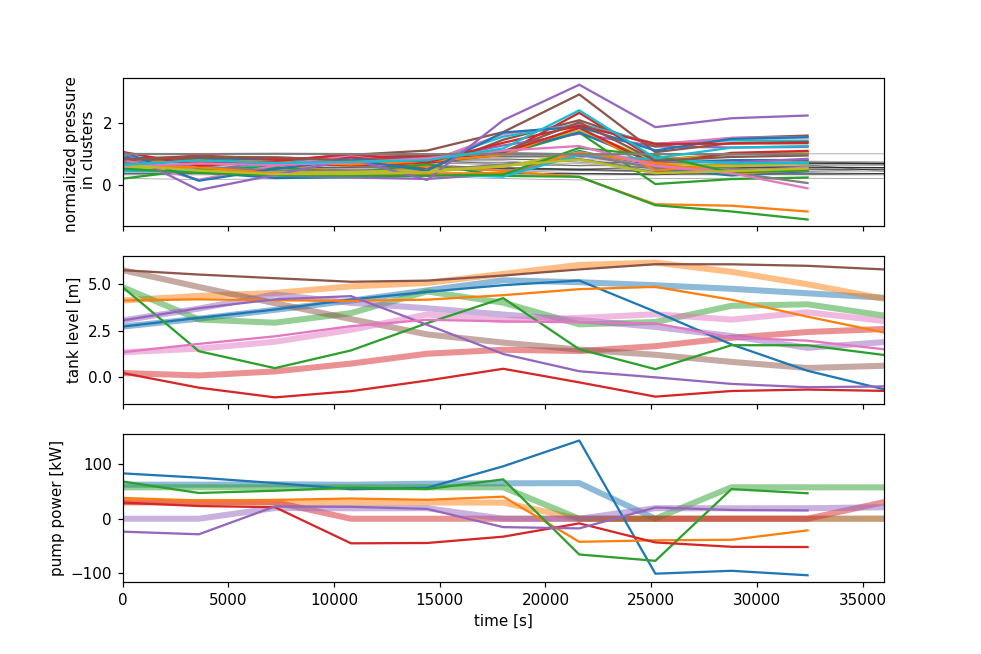

Text(0.5, 0, 'time [s]')

In [86]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


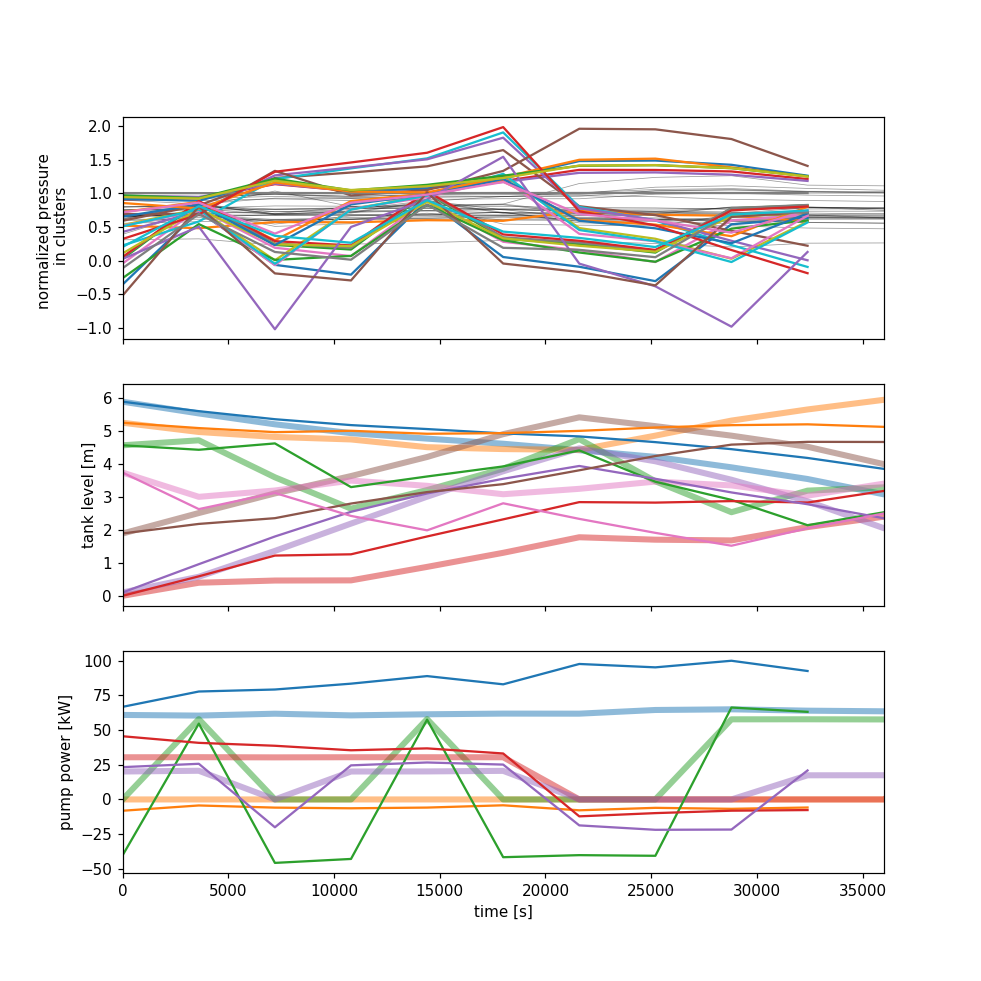

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')